# Calculations for spinon tight-binding hopping

## Geometry
Define the constants
$$\begin{align*}
b_{0}&= \frac{1}{4}(-1,\ -1,\ -1)\\
b_{1}&= \frac{1}{4}(+1,\ -1,\ -1)\\
b_{2}&= \frac{1}{4}(-1,\ +1,\ -1)\\
b_{3}&= \frac{1}{4}(-1,\ -1,\ +1)
\end{align*}$$

| Symbol                                                            | Meaning                                                  |
| ----------------------------------------------------------------- | -------------------------------------------------------- |
| $r, s, \mathbf{r, s}, r_{\alpha}, x$                              | Diamond lattice (tetrahedron) site (sublattice $\alpha$) |
| $i,j,r_A+b_\mu/2, r_B - b_\mu/2, r_\alpha + \eta_\alpha b_\mu/2$  | Pyrochlore lattice site                                  |
| $\mu, \nu$                                                        | Pyrochlore sublattice (0,1,2,3)                        |
| $\eta_{\alpha}, \eta_x$                                           | = +1 on 'up' / A tetrahedra, -1 on 'down' / B.           |


Standard practice is to index operators by their position in real-space based on the diamond FCC lattice. We write spins using the notation
$S^{z}_{r_{\alpha}+\eta_{\alpha}b_\mu/2}$
to mean "the spin belonging to the tetrahedron at $r_{\alpha}$ on sublattice $\mu$". This is rather cumbersome, so in these notes we will abbreviate this to 
$S^z_{r_\alpha,\mu}$


In [22]:
import pyrochlore_geometry as geom
import scipy.sparse as sp
import numpy as np
import numpy.linalg as LA
import matplotlib.pyplot as plt
import matplotlib as mpl


def wrap_cube(xyz, L):
    # remaps the argument to lie in [0,8L]^3
    xyz %= 8*L


In [2]:
def get_spin_sl(xyz):

    for mu, X in enumerate(geom.pyro):
        if np.all((xyz - X) %4 == 0):
            return mu
    return None

In [3]:
def load_gauge(afile): 
    '''
    Reads the gauge field config from file. The expected format is
    X     Y     Z     pyro_sl
    '''

    data = np.genfromtxt(afile, names=True)
    
    L = (len(data)/16)**(1/3)
    
    if np.abs(int(L) - L) > 1e-10:
        print("WARN: L is noninteger")
    
    L = int(L)
    
    N_tetra = 8*L**3

    A = np.zeros((N_tetra//2, 4))

    for row in data:
        xyz = np.array([row['X'], row['Y'], row['Z']], dtype=np.int32)
        gauge_conn = row['A']
        pyro_sl = int(row['pyro_sl'])
        # sanity check
        assert(pyro_sl == get_spin_sl(xyz))
        
        from_tetra = xyz - geom.pyro[pyro_sl]
        to_tetra = xyz + geom.pyro[pyro_sl]    
    
        idx_from = geom.get_tetra_idx(from_tetra, L)
        idx_to = geom.get_tetra_idx(to_tetra, L)

        # These should all be 'A' tetrahedra
        
        assert(idx_from%2 == 0) 
        # assert(np.allclose( A[idx_from, pyro_sl], 0))
        A[idx_from//2, pyro_sl] = gauge_conn
        # A[idx_to, pyro_sl] = -gauge_conn
    return A, L

In [4]:
def get_dual_fcc_locations(L):
    locs = []
    for ix in range(L):
        for iy in range(L):
            for iz in range(L):
                cell = 8*np.array([ix,iy,iz])
                for fcc in range(4):
                    locs.append(cell + geom.fcc_Ti[fcc])
    return locs

def get_hexagons(L):
    hexa_sites = [] # index by hexa_sites[dual_fcc_idx][sl] -> 6-member arr
    for I, r in enumerate(get_dual_fcc_locations(L)):
        row = []
        for mu in range(4):
            r_plaq = r + geom.pyro[mu]
            spin_sites = [r_plaq+y for y in geom.plaqt[mu] ]

            row.append([])
            for j, s in enumerate(spin_sites):
                nu = get_spin_sl(s)
                fcc = s - geom.pyro[nu]
                J = geom.get_tetra_idx(fcc,L)//2
                row[-1].append((J, nu))
                
        hexa_sites.append(row)
    return hexa_sites

def calc_fluxes(A):
    L = int( (A.shape[0]/4)**(1/3) )
    Phi = np.ones((A.shape[0], 4),dtype=np.complex128)
    hexa_sites = get_hexagons(L)
    for I, row in enumerate(hexa_sites):
        for nu, hex in enumerate(row):
            for i, (J, sl) in enumerate(hex):
                Phi[I][nu] *= np.exp(1j * A[J, sl] * (-1)**i )
   
    return np.angle(Phi)

# GMFT expansion
The Hamiltonian, without magnetic field, reads
$$
\begin{align}
H_{XYZ} =& \frac{J_{zz}}{2}\sum_{r_{\alpha}} Q_{r_{\alpha}}^{2} + \frac{J_{\pm}}{2}\sum_{r_{\alpha}}\sum_{\mu \neq \nu} S^{+}_{r_\alpha,\mu}S^{-}_{r_{\alpha},\nu} + h.c.\\
&+J_{\pm\pm}\sum_{r_{\alpha}}\sum_{\mu \neq \nu} S^+_{r_{\alpha},\mu}S^+_{r_{\alpha},\nu}+h.c.\\
% &+\sum_{\langle i j \rangle} \frac{J_\pm}{2} (\sigma_i^+\sigma_j^- + \sigma_i^-\sigma_j^+ )
&-\sum_{r_A, \mu} \frac{\boldsymbol{\hat{z}}_i \cdot \boldsymbol{B}}{2}
(S^+_{r_A,\mu} + S^-_{r_A,\mu}) 
\, . \nonumber
\end{align}
$$

After aplying the mapping
$$
\begin{align}
S^{+}_{r_{A},\mu} &= \frac{1}{2}\phi^{+}_{r_A}e^{iA_{r_{A},r_{A}+b_{\mu}}} \phi^-_{r_A+b_\mu}
\end{align}
$$

where $\phi$ is the spinon rotor creator/destroyer.

This generates the action
$$
\begin{align}
S_{GMFT} =& \int d\tau\sum_{x\in \rm Tetras} \frac{1}{2J_{zz}}\partial_{\tau}\phi^{*}_{x\tau}\partial_{\tau}\phi_{x \tau} + i \lambda_{x \tau}(\phi_{x \tau}^{*}\phi_{x \tau} -1) + H_{GMFT}
\\
H_{GMFT} =& + \frac{J_{\pm}}{8}\sum_{r_{\alpha}}\sum_{\mu \neq \nu} \phi^{+}_{r_{\alpha}+\mu}\phi^{-}_{r_{\alpha}+\nu}e^{i\eta_x(A_{r,r+\nu}-A_{r,r+\mu})} \\
&+\frac{J_{\pm\pm}}{8}\sum_{r_{\alpha}}\sum_{\mu \neq \nu} \phi^+_{r_{\alpha}}\phi^+_{r_{\alpha}}\phi^-_{r_{\alpha}+\mu}\phi^-_{r_{\alpha}+\nu}e^{i\eta_x(A_{r,r+\nu}+A_{r,r+\mu})}+h.c.\\
&-\sum_{r_A, \mu} \frac{\boldsymbol{\hat{z}}_\mu \cdot \boldsymbol{B}}{4} \left[ \phi_{r_A}^+ e^{iA_{r_A, r_A+b_\mu} } \phi_{r_A + b_\mu}^-  + h.c.\right]
\end{align}
$$

(For now, drop the $J_{\pm\pm}$ term since it makes life harder)

In $k$ space, one can (after replacing operator $A$ by c-numbers) use the Fourier transform
$$
\phi_{a}(\boldsymbol{k},\tau) = \frac{1}{\sqrt{N_{\text{super}}}}\sum_{X}\phi_{X+r_a}(\tau)e^{-i \boldsymbol{k}\cdot (\boldsymbol{X}+r_a)}
$$
to show that
$$
S_{GMFT} = \int_0^{\beta}d \tau\ \sum_{\boldsymbol{k}} \frac{1}{2J_{zz}}\partial_{\tau}\phi^{*}_{a\boldsymbol{k}\tau}\partial_{\tau}\phi_{a\boldsymbol{k}\tau} + \lambda \phi^{*}_{a\boldsymbol{k}\tau}\phi_{a\boldsymbol{k}\tau} + M_{ab}(\boldsymbol{k})\phi^{*}_{a\boldsymbol{k}\tau}\phi_{b\boldsymbol{k}\tau}
$$
wher the form of $M$ is set by the bond geometry in the enlarged unit cell. Explicitly,
$$
\begin{align*}
M(\boldsymbol{k}) =& - \frac{J_{\pm}}{4}\sum_{a=1}^{N_{tetra}}\sum_{\mu\neq \nu} \exp(i \eta_{a}(A_{r_a+b_\nu}-A_{r_a+b_\mu})-i \boldsymbol{k}\cdot(\boldsymbol{b}_{\mu}-\boldsymbol{b}_{\nu}))\ \sigma_{r_{a}+\eta b_\nu}\otimes\sigma_{r_a+\eta b_\mu}\\
&-\frac{1}{4}\sum_{a=1}^{f}\sum_{\mu=0}^{3}\boldsymbol{B}\cdot \hat{\boldsymbol{z}}_\mu
\left\{\exp(i\eta_{a}A_{r,r+b_{\mu}}-i \boldsymbol{k}\cdot \boldsymbol{b}_\mu)
~\sigma_{r_{a}+ b_\nu}\otimes\sigma_{r_a}+h.c.
\right\}
\end{align*}
$$
where $\sigma_r$ denotes the 1-by-$N_{tetra}$ tensor that is zero except for a 1 and the index of sublattice site $r$. $\eta_a$ is +1 on $A$ sites, -1 on $B$ sites.





## The workflow
We know the correct Ansatz for the 0-flux, $\pi$-flux and $\pi\pi00$ states, FF presents additional complications (specifically, it generally needs somewhat large unit cells to contain the a pattern -  e.g. $3\pi/4, \pi/4,\pi/4,\pi/4$ needs a $2\times 2 \times 2$ cubic cell).  Since it is non quantised, have
$\Phi_\mu(J_{\pm}, \boldsymbol{B})$ which we calculate by nL optimiation of the gauge field. This is then fed back to the mean-field $A$ Ansatz.

In [605]:
def diagonalise_M(K, A, Jpm = -1, B = [0,0,0]):
    '''
    Calculates the spinon hopping matrix and diagonalises it.
    - K is a list of k-space points, e.g. [k1, k2, k3, ... kM]
    - A is a [num_tetra/2, 4] matrix of gauge connections, interpreted as running out of the $A$ sites.
    - Jpm is the XXZ coupling
    - B is the magnetic field in global cubic coords

    Returns:
    - eps, a [M, num_tetra] list of sorted energies
    - U,   a [M, num_tetra, num_tetra] list of eigenvectors such that H[J] @ U[J] =  U[J] @ diag(eps[J])
    '''
    # infer the side length L from the size of A (assumes cubic supercell structure)
    L = (len(A)/4)**(1/3)
    L = int(L)
    num_tetra = (L**3)*8
    assert(num_tetra == len(A)*2)
    K = np.array(K)


    H = np.zeros((K.shape[0], num_tetra, num_tetra),dtype=np.complex128)

    # Project B onto the four local z axes
    Bs = (geom.axis @ B)[:,2]
    
    # the nearst neighbour (magnetic) hoppings
    for J0, x0 in enumerate(geom.get_tetra_locs(L)[::2]):
        for mu in range(4):
            x1 = x0 + 2*geom.pyro[mu]
            J1 = geom.get_tetra_idx(x1, L)

            hh = -Bs[mu]/4 *np.exp(1.0j*A[J0//2,mu] - 1.0j*K@(x1-x0))
            H[:, J0, J1] += hh
            H[:, J1, J0] += np.conj(hh)
            

    # the second neighbour (XXZ-like) hoppings
    for J0, x0 in enumerate(geom.get_tetra_locs(L)):
        eta = 1 - 2*(J0%2)
        for mu in range(4):
            x1 = x0 + eta*2*geom.pyro[mu]
            J1 = geom.get_tetra_idx(x1, L)
            
            for nu in np.mod(mu + np.array([1,2,3]), 4):
                x2 = x0 + eta*2*geom.pyro[nu]
                J2 = geom.get_tetra_idx(x2, L)
                
                if eta == 1:
                    # 'A' tetrahedron
                    H[:, J1, J2] += Jpm/4*np.exp(1.0j*(A[J0//2,mu] - A[J0//2,nu]) - 1.0j*K@(x1-x2))
                else:
                    H[:, J1, J2] += Jpm/4*np.exp(1.0j*(-A[J1//2,mu] + A[J2//2,nu]) - 1.0j*K@(x1-x2))
    
    eps, U = LA.eigh(H)
    # eps is a (M, num_tetra) array of unsorted eigenvalues
    # U is a (M, num_tetra, num_tetra) array of eigenvectors such that diag(eps[J,:]) = U[J,:,:]^* H[J,:,:] U[J,:,:]
    permute = np.argsort(eps,axis=-1) 
    for J, perm in enumerate(permute):
        eps[J, :] = eps[J, perm]
        U[J,:,:] = U[J,:,perm]
    
    return eps, U
    
    

## Self-Consistency

Each indivitual rotor has unit length. We enforce the local constraint $\phi_{x \tau}^{*}\phi_{x \tau} = 1~ \forall x\in\{\text{Tetras}\}$ with the Lagrange multiplier
$$
\int d\tau \sum_{x \in \text{Tetras}} i \lambda_{x \tau}(\phi_{x \tau}^{*}\phi_{x \tau} -1)
$$
This is hard. Instead, we make a large-$N$ approximation that relaxes this to the soft constraint,
$$\frac{1}{N_{tetra}} \sum_{x \in \text{Tetras}} \phi_{x \tau}^{*}\phi_{x \tau} = 1,$$
enforced by
$$
\int d\tau \sum_{x \in \text{Tetras}} i \lambda(\phi_{x \tau}^{*}\phi_{x \tau} -1)
$$
revealing $\lambda$ to be a mass term. (look idk what the factor of i is doing but its prolly fine)

After some manipulations, one can show that we must choose $\lambda$ to satisfy
$$
1 =  \frac{1}{N_{tetra}N_{super}}\sum_\boldsymbol{k} \sum_{l} \frac{ J_{zz}}{\mathcal{E}_{l}(\boldsymbol{k})}
$$
where $N_{tetra}$ is the numberof tetrahedra in the enlarged unit cell, $N_{super}$ is the number of unit cells, and $\mathcal{E}_{l}(\boldsymbol{k})= \sqrt{2J_{zz}(\lambda+\epsilon_l(\boldsymbol{k}))}$.

Such equations probably don't have a closed-form solution. Work in units of $J_{zz}$, and optimise.

In [487]:
import scipy.optimize as opt

def calc_lambda(A, Jpm = -1, B = [0,0,0], kappa=1):
    '''
    Calculates the spinon band structure along K.
    - A is a (num_tetra/2, 4) matrix of gauge connections
    - Jpm is the XXZ coupling
    - B is the magnetic field in global cubic coords

    Returns:
    - E, a (M, num_tetra) list of spinon energies corresponding to the k-points in K
    # - G, the zero-temperature spinon Green function at K
    '''
    # Essential that we sample K space uniformly.
    K = 2*np.pi * (np.random.rand(10000,3) - 0.5)
    
    eps, U = diagonalise_M(K, A, Jpm, B)
    num_tetra = len(eps)
    
    
    sr2 = np.sqrt(2)

    # let lambda = log(omega) for better numerics
    def SC_constr(lam):
        return np.mean( (lam + eps)**-0.5 )/sr2 - kappa

    # def grad_SC_constr(omega):
    #     return np.mean( -0.5*(np.log(omega) + eps)**-1.5 )/sr2

    # guess lambda in such a way that we don't end up with complex values
    min_eps = np.min(eps)
    max_eps = np.min(eps)
    
    lam_min = -min_eps+1e-12
    lam_max = lam_min + 10

    # x = np.linspace(lam_min, lam_max,100)
    try:
        lam =  opt.bisect(SC_constr, lam_min, lam_max)
    except ValueError:
        lam = lam_min
    
    return lam

    
# l_0flux = calc_lambda(A_zero) 
# l_piflux = 
# calc_lambda(A_pipi00_flux)
# this looks... singular as all hell. Seems that to get agreement, need to take lambda very close to e_min, i.e. literally just move the dispersion up.
# Alternatively, we may need to use a more sophisticated lambda ansatz.
calc_lambda(A_piflux, 1) 

1.1193693743581457

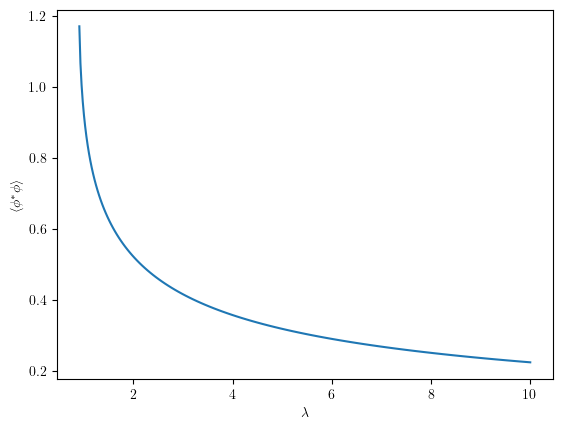

In [488]:
def plot_avg_rotor_len(A, Jpm, B=[0,0,0]):
    # Essential that we sample K space uniformly.
    K = 2*np.pi/4 * (np.random.rand(100000,3) - 0.5)
    
    eps, U = diagonalise_M(K, A, Jpm, B)
    num_tetra = len(eps)
    
    sr2 = np.sqrt(2)

    e_min = np.min(eps)-1e-6
    e_max = 10 #np.abs(np.max(eps))
    lam = np.geomspace(-e_min, e_max, 100)
    y = []
    for l in lam:
        y.append(np.mean( (l + eps)**-0.5)/sr2)
    
    plt.plot(lam, y)
    plt.xlabel(r'$\lambda$')
    plt.ylabel(r'$\langle \phi^* \phi \rangle$')

plot_avg_rotor_len(A_pipi00_flux,1/3,[1,1,0])

In [499]:
def spinon_spectrum(K, A, Jpm = -1, B = [0,0,0], kappa=1):
    '''
    Calculates the spinon spectrum along a particular k-space path.
    - K is a list of k-space points, e.g. [k1, k2, k3, ... kM]
    - A is a [num_tetra/2, 4] matrix of gauge connections, interpreted as running out of the $A$ sites.
    - Jpm is the XXZ coupling
    - B is the magnetic field in global cubic coords

    Returns:
    - E, a [M, num_tetra] list of sorted spinon energies
    - U,   a [M, num_tetra, num_tetra] list of eigenvectors such that H[J] @ U[J] =  U[J] @ diag(eps[J])
    '''
    # infer the side length L from the size of A (assumes cubic supercell structure)
    L = (len(A)/4)**(1/3)
    L = int(L)
    num_tetra = (L**3)*8
    assert(num_tetra == len(A)*2)
    K = np.array(K)

    lam =calc_lambda(A,Jpm, B, kappa)
    eps, U = diagonalise_M(K, A, Jpm = -1, B = [0,0,0])

    spinonE = np.sqrt( 2*(eps + lam))

    return spinonE, U
    


## Calculating the spectral weight

We now calculate
$$\begin{align}
\langle S^+(\mathbf{q}, t)S^-(\mathbf{-q},0)\rangle = 
&\frac{1}{4f^{2}N_{\rm spin }}\sum_{\begin{smallmatrix}\mathbf{k}&r_{A}&\mu\\ \mathbf{k}'&r_A'&\nu\end{smallmatrix}}
e^{iA_{r_A,r_A+b_\mu}-iA_{r_A',r_A'+b_\nu}}~e^{i \mathbf{k}\cdot \mathbf{b}_{\mu}-i \mathbf{k}'\cdot \mathbf{b}_{\nu}}
\times\left\langle 
\phi_{\mathbf{r}_{A}} ^{*}(\mathbf{k}+ \frac{\mathbf{q}}{2},t)\,
\phi_{\mathbf{r}_A+\mathbf{b}_\mu}(\mathbf{k}-\frac{\mathbf{q}}{2},t)~
\phi_{\mathbf{r}'_{A}+\mathbf{b}_\nu} ^{*}(\mathbf{k}'+ \frac{\mathbf{q}}{2},0)\,
\phi_{\mathbf{r}'_A}(\mathbf{k}'-\frac{\mathbf{q}}{2},0)
 \right\rangle
 \end{align}
$$
setting $K = \frac{1}{2}(k+k')$, $p=k-k'$, get
$$= \sum_{\mu,\nu} 
\left(\sum_{\mathbf{K}}\frac{1}{4f^2N_{\rm spin}} e^{i \mathbf{K}\cdot (b_\mu - b_\nu)}\right)
%
\sum_{\mathbf{p},r_A,r'_A} 
 e^{i \mathbf{p}\cdot (b_\mu + b_\nu)/2}
\mathcal{G}_{r_A,r'_A}(\mathbf{p}+\mathbf{q}, t)\mathcal{G}_{r'_A+b_\nu,r_A+b_\mu}(-\mathbf{p}+\mathbf{q}, -t)
$$

where we drop in the zero-temperature Green functions
$$
\mathcal{G}_{ab}(\mathbf{k},\omega_n) = \sum_{l=1}^{f}\frac{2J_{zz}U_{al} (\mathbf{k})U^{\dagger}_{lb}(\mathbf{k})}{-\omega_n^{2}+2J_{zz}(\lambda+\epsilon_{l}(\mathbf{k}))}
$$


In [593]:
import itertools
import time

def Green_residue(E, U, a):
    '''calculates the residue of the spinon Green function G(k, omega) at the a'th positive pole (residue the same at the negative poles)
    expects E, U to be the output of spinon_spectrum, in the format
    - E,  a [M, num_tetra] list of sorted spinon energies
    - U,  a [M, num_tetra, num_tetra] list of eigenvectors such that H[J] @ U[J] =  U[J] @ diag(eps[J])
    - a,  a 0,...,num_tetra-1 index

    returns a [M, num_tetra, num_tetra] array, the first index corresponding to k
    '''
    mask_E = np.ma.array(E, mask=False)
    mask_E.mask[:,a] = True
    omega = E[:,a]
    retval = 2*np.einsum('Jal, lJ, Jbl -> Jab', U, 1./(-omega**2+mask_E.T**2), U.conj())
    return retval + 2*np.einsum('Ja, J, Jb -> Jab', U[:,:,a], 1./(-2*omega), U[:,:,a].conj())


def Green(E, U, omega):
    '''calculates the spinon Green function G(k, omega) at the nonsingular point $\omega$.
    expects E, U to be the output of spinon_spectrum, in the format
    - E,  a [M, num_tetra] list of sorted spinon energies
    - U,  a [M, num_tetra, num_tetra] list of eigenvectors such that H[J] @ U[J] =  U[J] @ diag(eps[J])
    - omega,  a [M] list of scalars

    returns a [M, num_tetra, num_tetra] array, the first index corresponding to k
    '''
    return 2*np.einsum('Jal, lJ, Jbl -> Jab', U, 1./(-omega**2+E.T**2), U.conj())

def spec_weight(E_grid, Q, A, Jpm, B = [0,0,0], kappa=1, broaden=0.1):
    '''calculates the spectral weight
    expects E, U to be the output of spinon_spectrum, in the format
    - E,  a [M, num_tetra] list of sorted spinon energies
    - U,  a [M, num_tetra, num_tetra] list of eigenvectors such that H[J] @ U[J] =  U[J] @ diag(eps[J])
    '''
    # infer L from number of bands
    n_tetra = E.shape[-1]
    L = int( (n_tetra/4)**(1/3) )

    # run MC integration because anything else is too hard
    # Essential that we sample K space uniformly.
    P = 2*np.pi * (np.random.rand(1000,3) - 0.5)

    weight = np.zeros((Q.shape[0], E_grid.shape[0]),dtype=np.complex128)

    # figure out how to match things up
    A_locs= geom.get_tetra_locs(L)[::2]# the A sites only
    tetra_idx_1 = np.array([geom.get_tetra_idx(rA,L) for rA in A_locs],dtype=np.int32)


    tetra_idx_2l = np.array([[geom.get_tetra_idx(rA+2*geom.pyro[nu],L) for rA in A_locs] for nu in range(4)],dtype=np.int32)
    tetra_idx_2r = np.array([[geom.get_tetra_idx(rA+2*geom.pyro[mu],L) for rA in A_locs] for mu in range(4)],dtype=np.int32)
    
    for I, q in enumerate(Q):
        print(f"Q point {I+1}/{len(Q)+1}")
        t0 = time.monotonic_ns()    
        E1, U1 = spinon_spectrum( P+q, A, Jpm, B, kappa)
        E2, U2 = spinon_spectrum(-P+q, A, Jpm, B, kappa)
        print(f"diagonalised in {(time.monotonic_ns()-t0)//1000000} ms")
        
        for Ie, w in enumerate(E_grid):
            
            for mu, nu in itertools.product(range(4), range(4)):
                
                # singularities are at w2=E2 and w2 = E1-w
                # sum over singularities G(p+q, w + w2)G(-p+q, w2)
                pref = np.exp(1.0j*P@(geom.pyro[mu] + geom.pyro[nu])/2)
                for a in range(E2.shape[-1]):
                    w2 = E2[:,a]
                    # inefficient, should be the same if I subscript only U1 and U2
                    # "should" is not good enough, just check it first
                    weight[I,Ie] += np.einsum('Kal,Kla,K->',
                                              Green(E1, U1, w2+w)[:,tetra_idx_1,:][:,:,tetra_idx_1],
                                              Green_residue(E2, U2, a)[:,tetra_idx_2l[nu],:][:,:,tetra_idx_2r[mu]],
                                              pref)
                
                    w1 = E1[:,a]
                    weight[I,Ie] += np.einsum('Kal,Kla,K->',
                                              Green_residue(E1, U1, a)[:,tetra_idx_1,:][:,:,tetra_idx_1],
                                              Green(E2, U2, w1-w)[:,tetra_idx_2l[nu],:][:,:,tetra_idx_2r[mu]],
                                              pref)
                
    return weight
                
    
    

Q point 1/49
diagonalised in 566 ms
Q point 2/49
diagonalised in 511 ms
Q point 3/49
diagonalised in 610 ms
Q point 4/49
diagonalised in 662 ms
Q point 5/49
diagonalised in 699 ms
Q point 6/49
diagonalised in 536 ms
Q point 7/49
diagonalised in 554 ms
Q point 8/49
diagonalised in 668 ms
Q point 9/49
diagonalised in 525 ms
Q point 10/49
diagonalised in 551 ms
Q point 11/49
diagonalised in 575 ms
Q point 12/49
diagonalised in 528 ms
Q point 13/49
diagonalised in 727 ms
Q point 14/49
diagonalised in 549 ms
Q point 15/49
diagonalised in 568 ms
Q point 16/49
diagonalised in 590 ms
Q point 17/49
diagonalised in 583 ms
Q point 18/49
diagonalised in 522 ms
Q point 19/49
diagonalised in 513 ms
Q point 20/49
diagonalised in 604 ms
Q point 21/49
diagonalised in 607 ms
Q point 22/49
diagonalised in 614 ms
Q point 23/49
diagonalised in 517 ms
Q point 24/49
diagonalised in 526 ms
Q point 25/49
diagonalised in 554 ms
Q point 26/49
diagonalised in 558 ms
Q point 27/49
diagonalised in 511 ms
Q point 28

TypeError: Image data of dtype complex128 cannot be converted to float

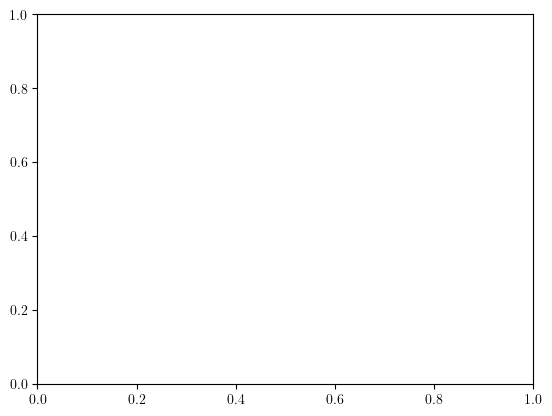

In [594]:
%%time

E_grid = np.linspace(0,4,20)
Q = kpath[::20]
S = spec_weight(E_grid, Q, A_piflux, Jpm=-1/3, B=[10,0,0])
plt.pcolormesh(S.T)

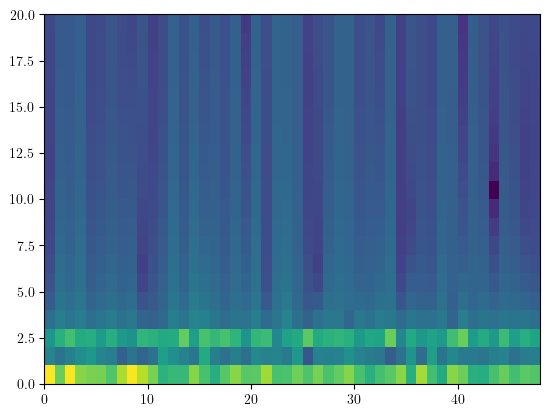

In [603]:
plt.pcolormesh(np.log(np.abs(S.T)+1e5))

In [462]:
high_symmetry_points = {
    '\\Gamma': [0.,0.,0.],
    'X': [1.,0.,0.],
    'W': [1.,0.5,0.],
    'K': [0.75,0.75,0.],
    'L': [0.5,0.5,0.5],
    'U': [1.0, 0.25,0.25]
} 

path = '\\Gamma X W K \\Gamma L U W'.split()

In [490]:
# load A and build the Hamiltonian

# manual zero flux
A_zero = np.zeros((4,4))

## manual piflux
A_piflux = np.zeros((4, 4))
A_piflux[0,:] = np.array([0,0,1,1])*np.pi
A_piflux[2,:] = np.array([0,0,1,1])*np.pi

## manual pipi00-flux
A_pipi00_flux = np.zeros((4, 4))
A_pipi00_flux[0,:] = np.array([0,0,0,1])*np.pi
A_pipi00_flux[2,:] = np.array([0,0,0,1])*np.pi

## manual pi/2 flux
A_pi2flux = np.zeros((4, 4))
A_pi2flux[1,:] = np.array([0,-1,1,0])*np.pi/2
A_pi2flux[2,:] = np.array([0,0,0,2])*np.pi/2
A_pi2flux[3,:] = np.array([0,1,1,0])*np.pi/2

# confirm correctness
print("Fluxes:")
print("π-flux:\n",calc_fluxes(A_piflux))
print("ππ00:\n",calc_fluxes(A_pipi00_flux))
print("π/2-flux:\n",calc_fluxes(A_pi2flux))

Fluxes:
π-flux:
 [[ 3.14159265  3.14159265 -3.14159265 -3.14159265]
 [-3.14159265 -3.14159265  3.14159265  3.14159265]
 [ 3.14159265  3.14159265 -3.14159265 -3.14159265]
 [-3.14159265 -3.14159265  3.14159265  3.14159265]]
ππ00:
 [[ 3.14159265  0.         -3.14159265  0.        ]
 [-3.14159265  0.          3.14159265  0.        ]
 [ 3.14159265  0.         -3.14159265  0.        ]
 [-3.14159265  0.          3.14159265  0.        ]]
π/2-flux:
 [[-1.57079633 -1.57079633 -1.57079633 -1.57079633]
 [-1.57079633 -1.57079633 -1.57079633 -1.57079633]
 [-1.57079633 -1.57079633 -1.57079633 -1.57079633]
 [-1.57079633 -1.57079633 -1.57079633 -1.57079633]]


In [491]:
B_tetras = [[ (geom.get_tetra_idx(tetra_locs[i]-2*geom.pyro[mu],1)//2, mu) for mu in range(4)] for i in range(1,8,2) ]  
def gauge_tetra(i):
    '''
    returns an A-field zero except for one tetrahhedron, which has all bonds constant.
    '''
    aa = np.zeros((4,4))
    if i%2 == 0:
        aa[i//2, :] += 1
    else:
        for j, mu in B_tetras[(i-1)//2]:
            aa[j, mu] += 1
    return aa

In [492]:
def mod2pi(x):
    return np.mod(x +np.pi,2*np.pi) - np.pi

def simplify_gauges(A):
    # Mostly fixes the gauge. Not completely-there are sitll discrete gauge transforms left after this.
    
    # uses the spanning tree
    # [0,0] [0,1] [0,2] [0,3]
    # [1,1] [2,2] [3,3]
    Anew = mod2pi(np.copy(A))

    # can subtract arbitrary numbers so long as I do it on every FCC Sl
    means = np.mean(Anew, axis=0)
    Anew[:,0] -= means[0]
    Anew[:,1] -= means[1]
    Anew[:,2] -= means[2]
    Anew[:,3] -= means[3]
    Anew = mod2pi(Anew)
    
    Anew -= gauge_tetra(0)*Anew[0,0]
    Anew -= gauge_tetra(2)*Anew[1,1]
    Anew -= gauge_tetra(4)*Anew[2,2]
    Anew -= gauge_tetra(6)*Anew[3,3]
    
    Anew -= gauge_tetra(3)*Anew[0,1]
    Anew -= gauge_tetra(5)*Anew[0,2]
    Anew -= gauge_tetra(7)*Anew[0,3]

    # make sure that the gauge was actually gauge
    assert np.allclose(np.exp(1j*(calc_fluxes(Anew) - calc_fluxes(A))), 1)
    
    return Anew


def elem(i, mu):
    z = np.zeros((4,4))
    z[i,mu] = 2*np.pi
    return z


In [493]:

# numerical 0-fluxes

A_zero_numerical = []
for filename in ["0_flux%001.gauge", "0_flux%002.gauge","0_flux%003.gauge"]:
    A_zero_numerical.append(load_gauge("/Users/alaricsanders/gh/QSI/data/a_finding/" + filename))

A_random, L_random = load_gauge("/Users/alaricsanders/gh/QSI/data/a_finding/random.gauge")

A_big, L_big = load_gauge("/Users/alaricsanders/gh/QSI/data/a_finding/0_flux_big.gauge")

N_tetra = 8*L**3
tetra_locs = geom.get_tetra_locs(L)


# Plotting the results


In [494]:
mpl.rcParams['text.usetex']=True
mpl.rcParams['text.latex.preamble']=r"\usepackage{\mathbf}"



def plot_dispersion(trace_list, hsp, path, Jpm=None, B=np.array([0,0,0]), ax=None):
    if ax is None:
        plt.close('all')
        fig, ax = plt.subplots()
    tpath, kpath, ticks = geom.generate_path(hsp, path, 200)
    cmap = mpl.colormaps['Accent']
    for j, tr in enumerate(trace_list):
        this_jpm = Jpm
        if 'Jpm' in tr:
            this_jpm = tr['Jpm']
        if this_jpm is None:
            raise ValueError("Jpm must be specified for either the trace or as a default")

        this_B = B
        if 'B' in tr:
            this_B = tr['B']
        
        E, _ = spinon_spectrum((kpath+tr['kshift'])*2*np.pi/8, tr['A'], B=this_B, Jpm=this_jpm)
    
        kwargs = dict(color=cmap(j/(len(trace_list)+1)))
        for k in tr['plot_args']:
            kwargs[k] = tr['plot_args'][k]
        ax.plot(tpath, E, **kwargs)


    ax.set_xticks(ticks)
    ax.set_xticklabels(f'${x}$' for x in path)

    return fig, ax



In [431]:
def rotate_dict(d, R):
    ''' Applies the rotation matrix R to all elements of dict d, returning a new dict
    '''
    retval = {}
    for k in d:
        retval[k] = np.array(R)@d[k]
    return retval

/var/folders/zw/92jnrf1n0710vn256dpg6bsw0000gn/T/ipykernel_5262/3861951227.py:23: RuntimeWarning: invalid value encountered in sqrt
  spinonE = np.sqrt( 2*(eps + lam))


Text(0.5, 1.0, '0-flux (cubic unit cell, 8 d.s.)')

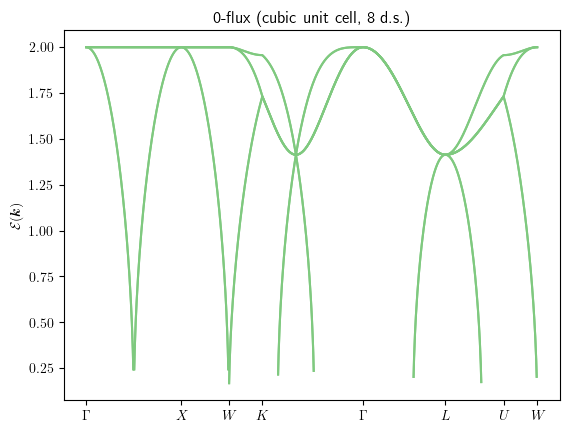

In [495]:
f, ax = plot_dispersion([
    dict(A=A_zero, kshift=[0,0,0],plot_args=dict(ls='-'))
],
                        B=[0,0,0], Jpm=-1/3,
                       hsp = high_symmetry_points,
                       path = path)

ax.set_ylabel(r'$\mathcal{E}(\boldsymbol{k})$')
ax.set_title('0-flux (cubic unit cell, 8 d.s.)')

Text(0.5, 1.0, '$\\pi$-flux (cubic unit cell, 8 d.s.)')

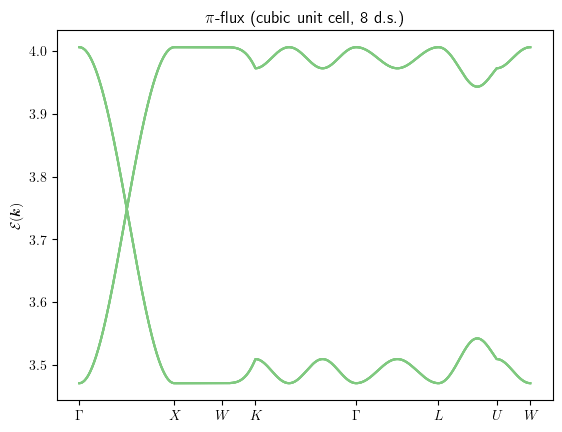

In [599]:
f, ax = plot_dispersion([
    dict(A=A_piflux, kshift=[0.5,0,0],plot_args=dict(ls='-'))
],
                        B=[10,0,0],
                       hsp = hsp_y,
                       path = path,Jpm=1/3)

ax.set_ylabel(r'$\mathcal{E}(\boldsymbol{k})$')
ax.set_title('$\pi$-flux (cubic unit cell, 8 d.s.)')

In [482]:
hsp_x = rotate_dict(high_symmetry_points, np.eye(3))
hsp_y = rotate_dict(high_symmetry_points, [[0,0,1],[1,0,0],[0,1,0]])
hsp_z = rotate_dict(high_symmetry_points, [[0,1,0],[0,0,1],[1,0,0]])

print(hsp_x)
print(hsp_y)
print(hsp_z)

{'\\Gamma': array([0., 0., 0.]), 'X': array([1., 0., 0.]), 'W': array([1. , 0.5, 0. ]), 'K': array([0.75, 0.75, 0.  ]), 'L': array([0.5, 0.5, 0.5]), 'U': array([1.  , 0.25, 0.25])}
{'\\Gamma': array([0., 0., 0.]), 'X': array([0., 1., 0.]), 'W': array([0. , 1. , 0.5]), 'K': array([0.  , 0.75, 0.75]), 'L': array([0.5, 0.5, 0.5]), 'U': array([0.25, 1.  , 0.25])}
{'\\Gamma': array([0., 0., 0.]), 'X': array([0., 0., 1.]), 'W': array([0.5, 0. , 1. ]), 'K': array([0.75, 0.  , 0.75]), 'L': array([0.5, 0.5, 0.5]), 'U': array([0.25, 0.25, 1.  ])}


Text(0.5, 1.0, '$\\pi\\pi00$-flux (cubic unit cell, 8d.s.)')

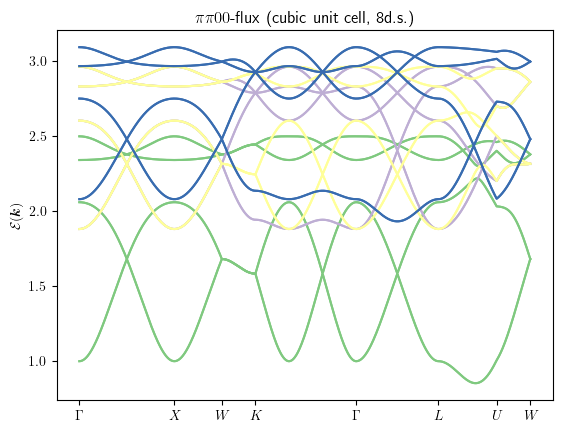

In [497]:
traces = []
for i, perm in enumerate([[0,1,2,3],[1,2,3,0],[2,3,0,1],[3,0,1,2]]):
    traces.append(dict(
        A=A_pipi00_flux[:,perm], 
        kshift=[0,0,0],
        plot_args=dict(ls='-')
    ))
    

f, ax = plot_dispersion(traces,B=[3,3,0], Jpm=-0.2,hsp=hsp_z, path=path)


ax.set_ylabel(r'$\mathcal{E}(\boldsymbol{k})$')
ax.set_title('$\pi\pi00$-flux (cubic unit cell, 8d.s.)')

/var/folders/zw/92jnrf1n0710vn256dpg6bsw0000gn/T/ipykernel_5262/3861951227.py:23: RuntimeWarning: invalid value encountered in sqrt
  spinonE = np.sqrt( 2*(eps + lam))


Text(0.5, 1.0, 'Gauged $\\pi$-flux (cubic unit cell, 8d.s.)')

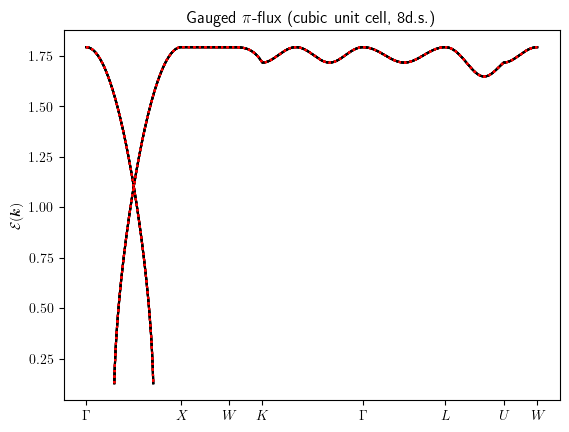

In [486]:
# build a random test A
A_test = np.copy(A_piflux)

for i in range(8):
    A_test += gauge_tetra(i)*(1.-2.*np.random.rand())
for i in range(16):
    A_test += elem(np.random.randint(0,4),np.random.randint(0,4))

dk = np.array([1,.2,3])
A_shift = np.copy(A_test)

A_shift += np.array([ [np.sum(dk), dk[0],dk[1],dk[2]] for i in range(4) ])
# gauging did not affect the fluxes at all
assert(np.allclose(np.exp(1j*(calc_fluxes(A_shift) - calc_fluxes(A_test))), 1))

f, ax = plot_dispersion([
    dict(A=A_test, kshift=[0,0,0],plot_args=dict(ls='-', color='k')),
    dict(A=A_shift, kshift=dk/np.pi,plot_args=dict(ls=':', color='r'))
],B=[0,0,0], path=path, hsp=hsp_z, Jpm=-1/3)
# note the nontrivial kshift in the A_shift one

ax.set_ylabel(r'$\mathcal{E}(\boldsymbol{k})$')
ax.set_title('Gauged $\pi$-flux (cubic unit cell, 8d.s.)')

CPU times: user 23min 27s, sys: 15min 16s, total: 38min 44s
Wall time: 13min 12s


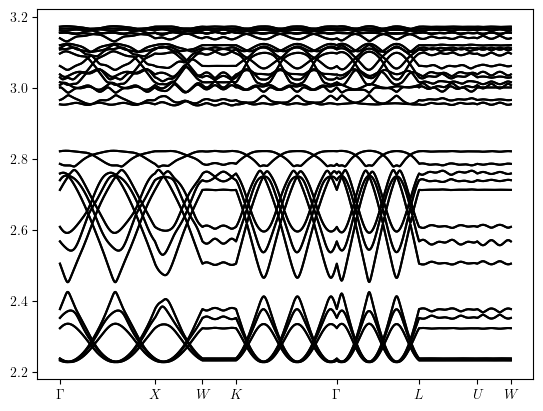

In [409]:
%%time

# The FF Case
A_FF_even,_ = load_gauge("/Users/alaricsanders/gh/QSI/data/a_finding/FF_even.gauge")

f, ax = plot_dispersion([
    dict(A=A_FF_even, kshift=[0,0,0],plot_args=dict(ls='-', color='k')),
],B=[3,3,3], hsp=hsp_z, path=path)



## Saddle Point approximation for the quartic term

We can use the MF decoupling

$$
\begin{align*}
ss\phi_1^{+}\phi_2^{+}\phi_{3}\phi_{4} \mapsto \langle s \rangle\langle s \rangle\Big[\langle \phi_{1}^+\phi_{2}^+\rangle\phi_{3}^-\phi_{4}^- +  \phi_{1}^+\phi_{2}^+\langle\phi_{3}^-\phi_{4}^-\rangle\\
+\langle \phi_{1}^+\phi_{3}^-\rangle\phi_{2}^+\phi_{4}^- +  \phi_{1}^+\phi_{3}^-\langle\phi_{2}^+\phi_{4}^-\rangle\\
\langle \phi_{1}^+\phi_{4}^-\rangle\phi_{2}^+\phi_{3}^- +  \phi_{1}^+\phi_{4}^-\langle\phi_{2}^+\phi_{3}^-\rangle
\Big]
\end{align*}
$$

to render the Hamiltonian quadratic.

